# Agricultural Prediction System - Model Training and Analysis

This notebook covers the complete pipeline for:
- Crop Yield Prediction
- Disease Prediction and Fertilizer Suggestion
- Weather Pattern Analysis
- Data Visualizations for Agricultural Production

## Dataset Overview
- **Pesticides Data**: Usage patterns across countries and years
- **Rainfall Data**: Average annual rainfall by region
- **Temperature Data**: Historical temperature records
- **Yield Data**: Crop production yields for various crops

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load and preprocess datasets
print("Loading datasets...")

# Load pesticides data
pesticides = pd.read_csv('dataset/pesticides.csv')
pesticides['Value'] = pd.to_numeric(pesticides['Value'], errors='coerce')

# Load rainfall data
rainfall = pd.read_csv('dataset/rainfall.csv')

# Load temperature data
temp = pd.read_csv('dataset/temp.csv')
temp['avg_temp'] = pd.to_numeric(temp['avg_temp'], errors='coerce')

# Load yield data
yield_df = pd.read_csv('dataset/yield_df.csv')
yield_main = pd.read_csv('dataset/yield.csv')

print("Datasets loaded successfully!")
print(f"Pesticides data shape: {pesticides.shape}")
print(f"Rainfall data shape: {rainfall.shape}")
print(f"Temperature data shape: {temp.shape}")
print(f"Yield data shape: {yield_df.shape}")

Loading datasets...
Datasets loaded successfully!
Pesticides data shape: (4349, 7)
Rainfall data shape: (6727, 3)
Temperature data shape: (71311, 3)
Yield data shape: (28242, 8)


## 1. Exploratory Data Analysis and Visualizations

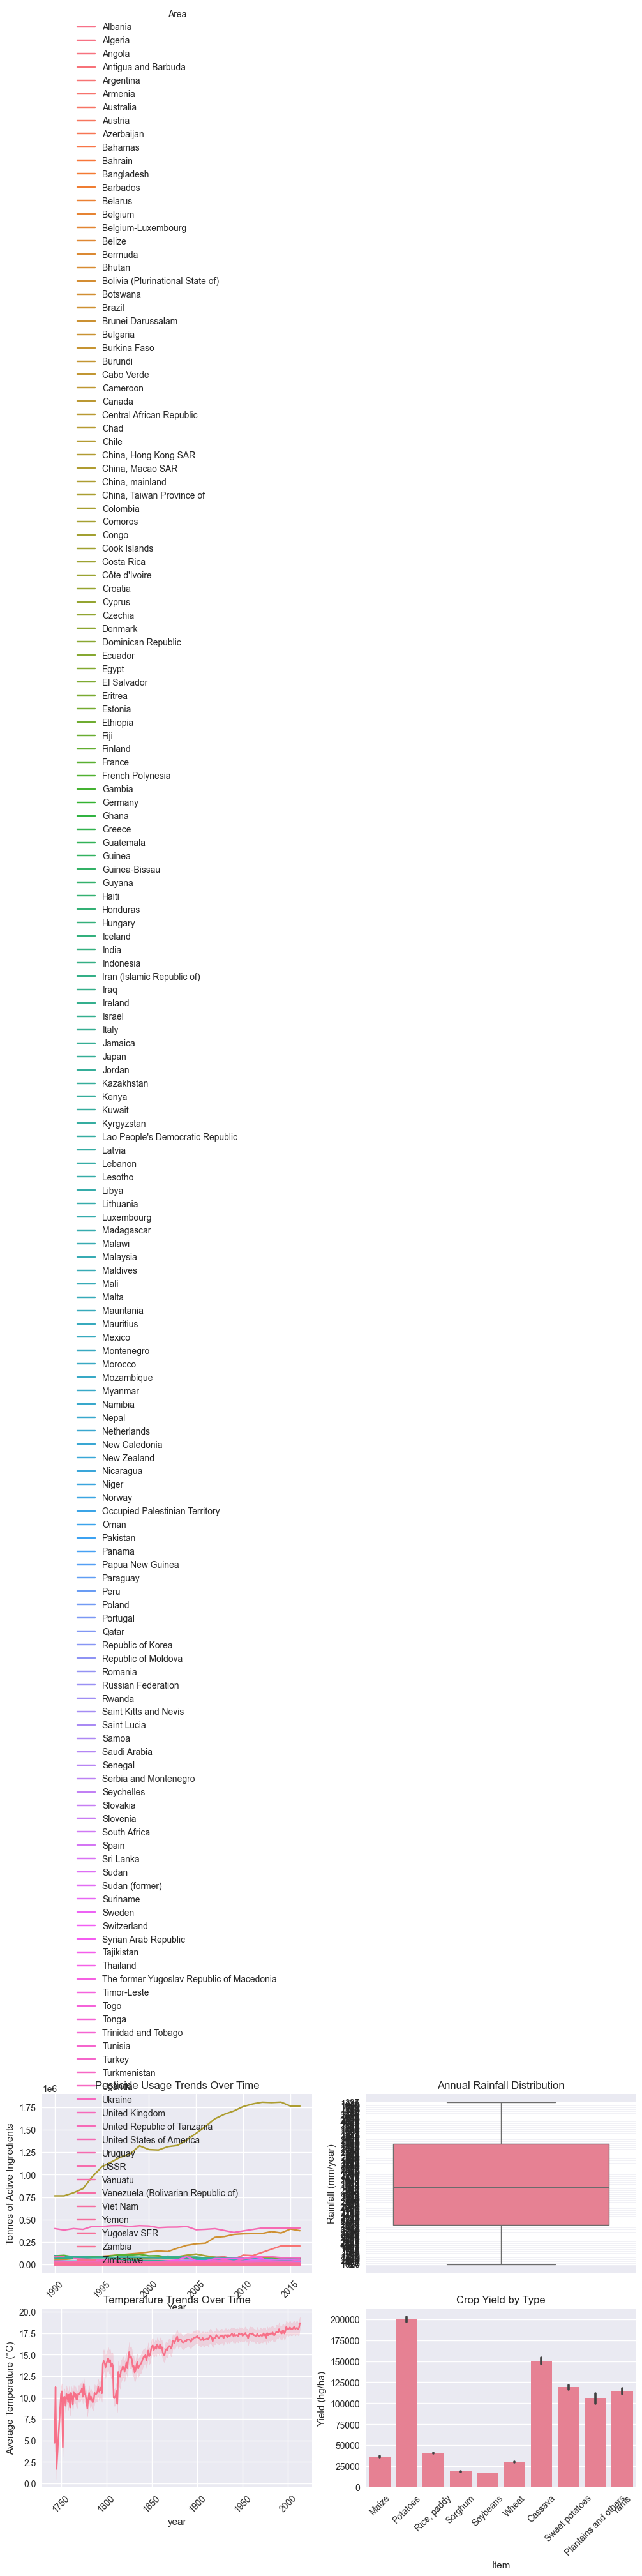

In [4]:
# Create comprehensive visualizations for agricultural data

# 1. Pesticide Usage Trends
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
pesticides_clean = pesticides.dropna()
sns.lineplot(data=pesticides_clean, x='Year', y='Value', hue='Area')
plt.title('Pesticide Usage Trends Over Time')
plt.ylabel('Tonnes of Active Ingredients')
plt.xticks(rotation=45)

# 2. Rainfall Distribution
plt.subplot(2, 2, 2)
sns.boxplot(data=rainfall, y='average_rain_fall_mm_per_year')
plt.title('Annual Rainfall Distribution')
plt.ylabel('Rainfall (mm/year)')

# 3. Temperature Trends
plt.subplot(2, 2, 3)
temp_clean = temp.dropna()
sns.lineplot(data=temp_clean, x='year', y='avg_temp')
plt.title('Temperature Trends Over Time')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)

# 4. Crop Yield Distribution
plt.subplot(2, 2, 4)
if 'hg/ha_yield' in yield_df.columns:
    sns.barplot(data=yield_df, x='Item', y='hg/ha_yield')
    plt.title('Crop Yield by Type')
    plt.ylabel('Yield (hg/ha)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2. Data Preprocessing for Machine Learning Models

In [5]:
# Prepare integrated dataset for modeling
def prepare_modeling_data():
    """
    Merge and prepare data for various prediction models
    """
    # Start with yield data as base
    base_data = yield_df.copy()
    
    # Merge with pesticides data
    pest_data = pesticides[['Area', 'Year', 'Value']].copy()
    pest_data.rename(columns={'Value': 'pesticide_usage'}, inplace=True)
    
    # Merge datasets
    modeling_data = pd.merge(base_data, pest_data, on=['Area', 'Year'], how='left')
    
    # Fill missing pesticide data
    if 'pesticides_tonnes' in modeling_data.columns:
        modeling_data['pesticide_usage'] = modeling_data['pesticide_usage'].fillna(modeling_data['pesticides_tonnes'])
    
    # Clean and prepare features
    modeling_data = modeling_data.dropna()
    
    return modeling_data

# Prepare data
model_data = prepare_modeling_data()
print(f"Prepared modeling dataset shape: {model_data.shape}")
print("\nColumns available for modeling:")
print(model_data.columns.tolist())

Prepared modeling dataset shape: (28242, 9)

Columns available for modeling:
['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'pesticide_usage']


## 3. Crop Yield Prediction Model

Yield Prediction Model Performance:
RMSE: 93382.60
Features used: ['average_rain_fall_mm_per_year', 'pesticide_usage', 'avg_temp']


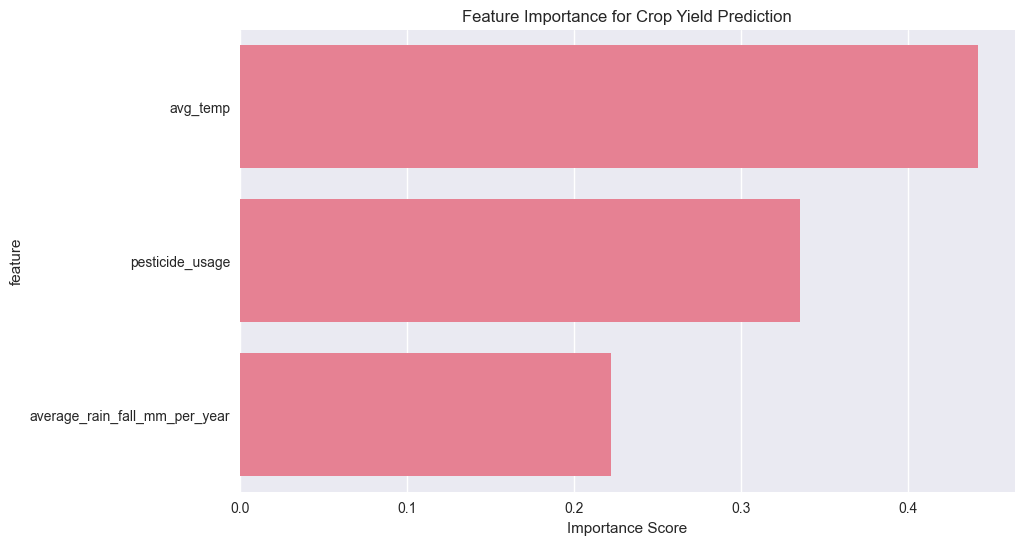

In [6]:
# Crop Yield Prediction Model
def train_yield_prediction_model(data):
    """
    Train a model to predict crop yield based on environmental factors
    """
    # Define features and target
    feature_cols = ['average_rain_fall_mm_per_year', 'pesticide_usage', 'avg_temp']
    target_col = 'hg/ha_yield' if 'hg/ha_yield' in data.columns else 'hg_ha_yield'
    
    # Filter available features
    available_features = [col for col in feature_cols if col in data.columns]
    
    if not available_features or target_col not in data.columns:
        print("Required columns not found. Using available numerical columns.")
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) < 2:
            return None, None, None
        available_features = numeric_cols[:-1]  # All but last as features
        target_col = numeric_cols[-1]  # Last as target
    
    X = data[available_features]
    y = data[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # Predictions and evaluation
    y_pred = rf_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"Yield Prediction Model Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"Features used: {available_features}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance for Crop Yield Prediction')
    plt.xlabel('Importance Score')
    plt.show()
    
    return rf_model, scaler, feature_importance

# Train the model
yield_model, yield_scaler, yield_features = train_yield_prediction_model(model_data)

## 4. Disease Risk Prediction Model

Disease Risk Prediction Model Performance:
Accuracy: 1.00
Risk categories: ['High' 'Low' 'Medium']


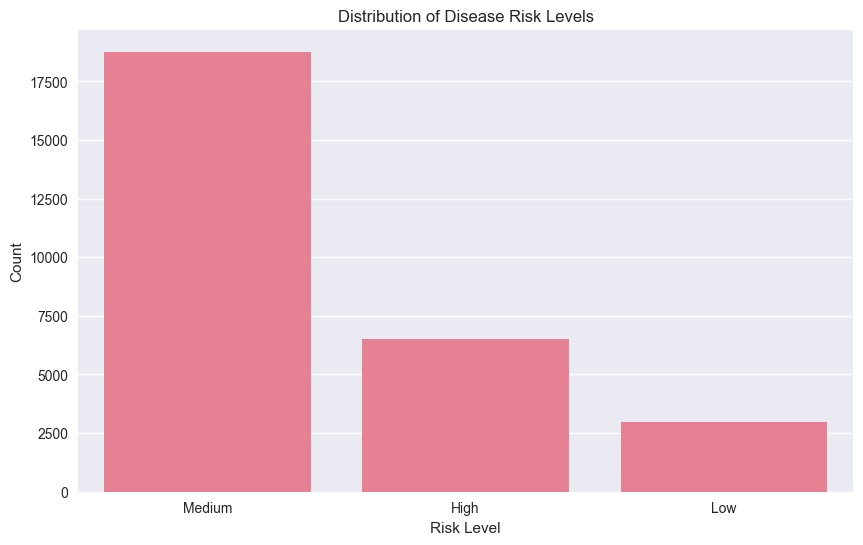

In [7]:
# Disease Risk Prediction Model
def create_disease_risk_model(data):
    """
    Create a model to predict disease risk based on environmental conditions
    """
    # Create synthetic disease risk labels based on environmental conditions
    # High risk: High humidity (rainfall) + moderate temperature + low pesticide use
    
    model_df = data.copy()
    
    # Create disease risk categories
    def calculate_disease_risk(row):
        rainfall = row.get('average_rain_fall_mm_per_year', 0)
        temp = row.get('avg_temp', 20)
        pesticide = row.get('pesticide_usage', 0)
        
        # Risk scoring logic
        risk_score = 0
        
        # High rainfall increases disease risk
        if rainfall > 1000:
            risk_score += 2
        elif rainfall > 500:
            risk_score += 1
        
        # Moderate temperatures increase risk
        if 15 <= temp <= 25:
            risk_score += 2
        elif 10 <= temp <= 30:
            risk_score += 1
        
        # Low pesticide use increases risk
        if pesticide < 100:
            risk_score += 1
        
        # Classify risk level
        if risk_score >= 4:
            return 'High'
        elif risk_score >= 2:
            return 'Medium'
        else:
            return 'Low'
    
    model_df['disease_risk'] = model_df.apply(calculate_disease_risk, axis=1)
    
    # Prepare features
    feature_cols = ['average_rain_fall_mm_per_year', 'avg_temp', 'pesticide_usage']
    available_features = [col for col in feature_cols if col in model_df.columns]
    
    if len(available_features) < 2:
        print("Insufficient features for disease prediction model")
        return None, None, None
    
    X = model_df[available_features]
    y = model_df['disease_risk']
    
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_scaled, y_train)
    
    # Predictions and evaluation
    y_pred = rf_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Disease Risk Prediction Model Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Risk categories: {label_encoder.classes_}")
    
    # Visualize risk distribution
    plt.figure(figsize=(10, 6))
    risk_counts = model_df['disease_risk'].value_counts()
    sns.barplot(x=risk_counts.index, y=risk_counts.values)
    plt.title('Distribution of Disease Risk Levels')
    plt.xlabel('Risk Level')
    plt.ylabel('Count')
    plt.show()
    
    return rf_classifier, scaler, label_encoder

# Train disease prediction model
disease_model, disease_scaler, disease_encoder = create_disease_risk_model(model_data)

## 5. Fertilizer Recommendation System

Sample Fertilizer Recommendations:
Original_Crop Matched_Crop  Rainfall  N_kg_ha  P_kg_ha  K_kg_ha
        Maize        Maize    1485.0       96       54       44
     Potatoes     Potatoes    1485.0      120       72      120
  Rice, paddy         Rice    1485.0       90       40       60
      Sorghum        Maize    1485.0       96       54       44
     Soybeans     Soybeans    1485.0       16       32       72
        Wheat        Maize    1485.0       96       54       44
        Maize        Maize    1485.0       96       54       44
     Potatoes     Potatoes    1485.0      120       72      120
  Rice, paddy         Rice    1485.0       90       40       60
      Sorghum        Maize    1485.0       96       54       44


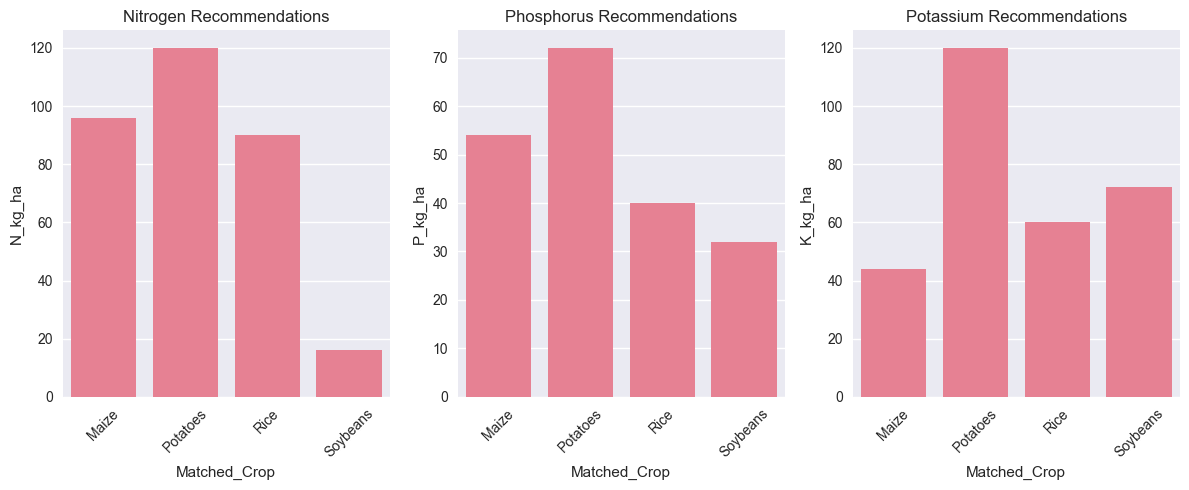

In [8]:
# Fertilizer Recommendation System
def create_fertilizer_recommendations():
    """
    Create a rule-based fertilizer recommendation system
    """
    
    fertilizer_rules = {
        'Maize': {
            'base_npk': {'N': 120, 'P': 60, 'K': 40},
            'rainfall_adjustment': {
                'low': {'N': 1.2, 'P': 1.1, 'K': 1.0},
                'medium': {'N': 1.0, 'P': 1.0, 'K': 1.0},
                'high': {'N': 0.8, 'P': 0.9, 'K': 1.1}
            }
        },
        'Rice': {
            'base_npk': {'N': 100, 'P': 50, 'K': 50},
            'rainfall_adjustment': {
                'low': {'N': 1.3, 'P': 1.2, 'K': 1.0},
                'medium': {'N': 1.0, 'P': 1.0, 'K': 1.0},
                'high': {'N': 0.9, 'P': 0.8, 'K': 1.2}
            }
        },
        'Potatoes': {
            'base_npk': {'N': 150, 'P': 80, 'K': 120},
            'rainfall_adjustment': {
                'low': {'N': 1.2, 'P': 1.1, 'K': 1.1},
                'medium': {'N': 1.0, 'P': 1.0, 'K': 1.0},
                'high': {'N': 0.8, 'P': 0.9, 'K': 1.0}
            }
        },
        'Soybeans': {
            'base_npk': {'N': 20, 'P': 40, 'K': 60},  # Lower N due to nitrogen fixation
            'rainfall_adjustment': {
                'low': {'N': 1.5, 'P': 1.2, 'K': 1.1},
                'medium': {'N': 1.0, 'P': 1.0, 'K': 1.0},
                'high': {'N': 0.8, 'P': 0.8, 'K': 1.2}
            }
        }
    }
    
    def get_fertilizer_recommendation(crop, rainfall, soil_type='medium'):
        """
        Get fertilizer recommendation for a specific crop and conditions
        """
        crop_key = crop.replace(',', '').replace(' paddy', '').strip()
        
        # Find matching crop (case-insensitive)
        matching_crop = None
        for crop_name in fertilizer_rules.keys():
            if crop_name.lower() in crop_key.lower() or crop_key.lower() in crop_name.lower():
                matching_crop = crop_name
                break
        
        if not matching_crop:
            matching_crop = 'Maize'  # Default
        
        base_npk = fertilizer_rules[matching_crop]['base_npk']
        
        # Determine rainfall category
        if rainfall < 500:
            rainfall_cat = 'low'
        elif rainfall < 1200:
            rainfall_cat = 'medium'
        else:
            rainfall_cat = 'high'
        
        adjustments = fertilizer_rules[matching_crop]['rainfall_adjustment'][rainfall_cat]
        
        # Calculate adjusted NPK
        recommended_npk = {
            'N': round(base_npk['N'] * adjustments['N']),
            'P': round(base_npk['P'] * adjustments['P']),
            'K': round(base_npk['K'] * adjustments['K'])
        }
        
        return recommended_npk, matching_crop
    
    # Test recommendations on sample data
    if not model_data.empty:
        recommendations = []
        for _, row in model_data.head(10).iterrows():
            crop = row.get('Item', 'Maize')
            rainfall = row.get('average_rain_fall_mm_per_year', 800)
            npk, matched_crop = get_fertilizer_recommendation(crop, rainfall)
            recommendations.append({
                'Original_Crop': crop,
                'Matched_Crop': matched_crop,
                'Rainfall': rainfall,
                'N_kg_ha': npk['N'],
                'P_kg_ha': npk['P'],
                'K_kg_ha': npk['K']
            })
        
        rec_df = pd.DataFrame(recommendations)
        print("Sample Fertilizer Recommendations:")
        print(rec_df.to_string(index=False))
        
        # Visualize NPK recommendations
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 3, 1)
        sns.barplot(data=rec_df, x='Matched_Crop', y='N_kg_ha')
        plt.title('Nitrogen Recommendations')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 2)
        sns.barplot(data=rec_df, x='Matched_Crop', y='P_kg_ha')
        plt.title('Phosphorus Recommendations')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 3)
        sns.barplot(data=rec_df, x='Matched_Crop', y='K_kg_ha')
        plt.title('Potassium Recommendations')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    return get_fertilizer_recommendation

# Create fertilizer recommendation system
fertilizer_recommender = create_fertilizer_recommendations()

## 6. Weather Pattern Analysis

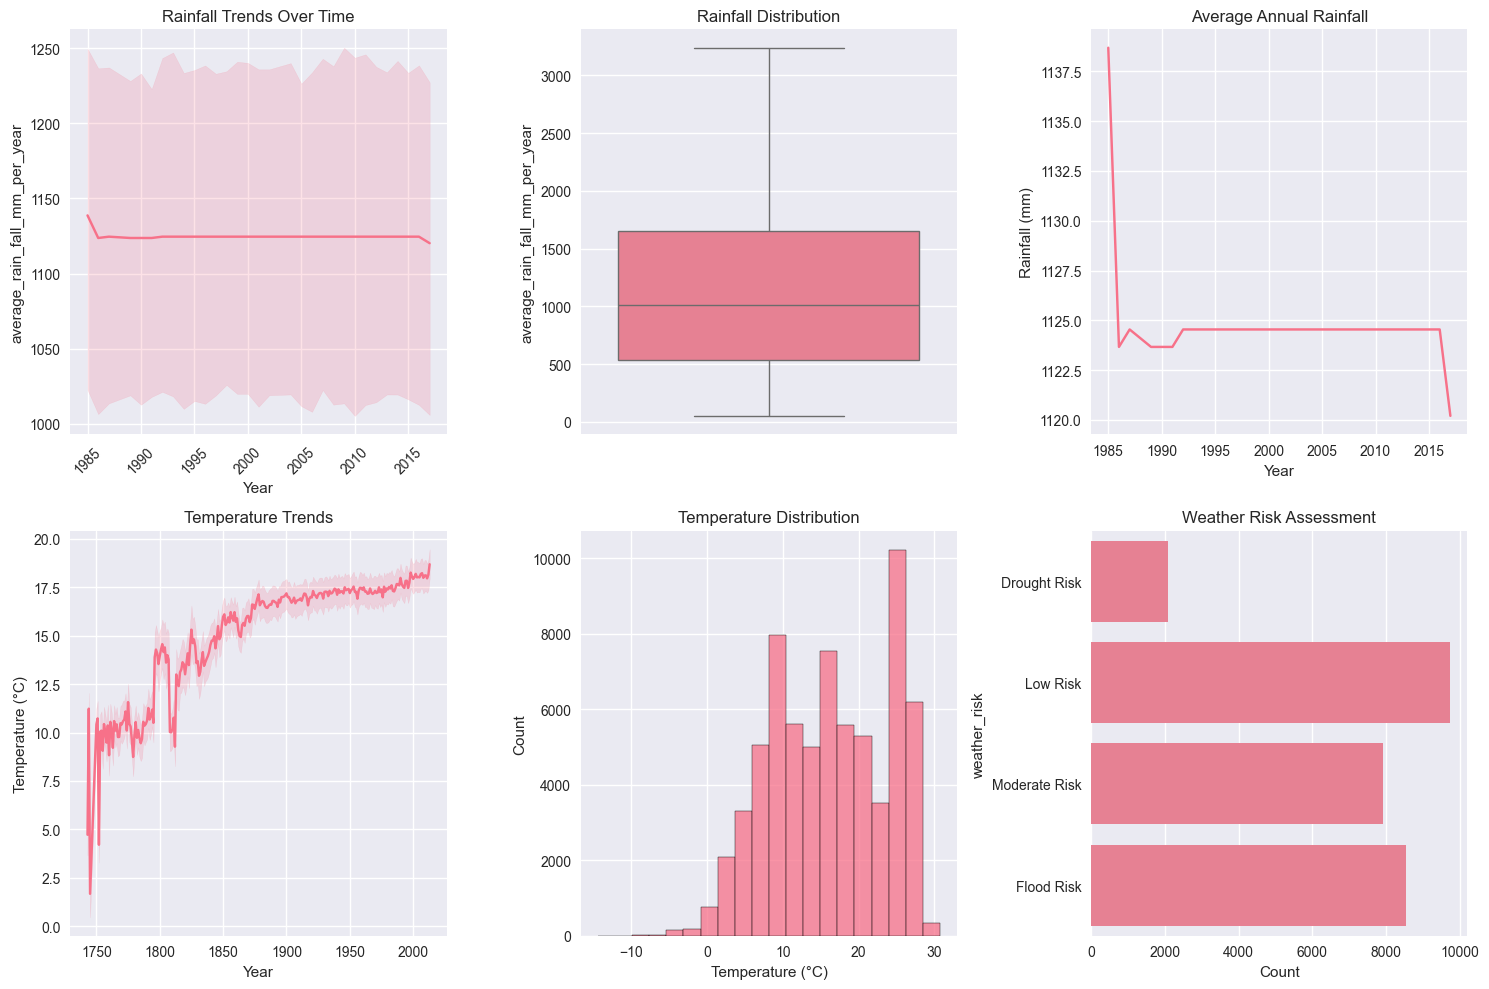


Weather Predictions (Next 5 Years):
Year 2018: 1123.2 mm
Year 2019: 1123.1 mm
Year 2020: 1123.1 mm
Year 2021: 1123.0 mm
Year 2022: 1122.9 mm


In [11]:
# Weather Pattern Analysis and Prediction
def analyze_weather_patterns():
    """
    Analyze weather patterns and create simple forecasting models
    """
    plt.figure(figsize=(15, 10))
    
    # Make a local clean copy for analysis
    rainfall_clean = rainfall.copy() if 'rainfall' in globals() else None
    temp_clean = temp.copy() if 'temp' in globals() else None
    model_data_local = model_data.copy() if 'model_data' in globals() else None

    # -----------------------------
    # Rainfall trend analysis
    # -----------------------------
    if rainfall_clean is not None and not rainfall_clean.empty:
        # Convert Year and rainfall to numeric, coerce invalid values to NaN
        rainfall_clean['Year'] = pd.to_numeric(rainfall_clean['Year'], errors='coerce')
        rainfall_clean['average_rain_fall_mm_per_year'] = pd.to_numeric(
            rainfall_clean['average_rain_fall_mm_per_year'], errors='coerce'
        )

        # Plot 1: Rainfall Trends Over Time
        plt.subplot(2, 3, 1)
        sns.lineplot(data=rainfall_clean, x='Year', y='average_rain_fall_mm_per_year')
        plt.title('Rainfall Trends Over Time')
        plt.xticks(rotation=45)

        # Plot 2: Rainfall Distribution
        plt.subplot(2, 3, 2)
        sns.boxplot(data=rainfall_clean, y='average_rain_fall_mm_per_year')
        plt.title('Rainfall Distribution')

        # Plot 3: Average Annual Rainfall (after groupby)
        plt.subplot(2, 3, 3)
        yearly_avg = rainfall_clean.groupby('Year')['average_rain_fall_mm_per_year'].mean()
        sns.lineplot(x=yearly_avg.index, y=yearly_avg.values)
        plt.title('Average Annual Rainfall')
        plt.xlabel('Year')
        plt.ylabel('Rainfall (mm)')

    # -----------------------------
    # Temperature analysis
    # -----------------------------
    if temp_clean is not None and not temp_clean.empty:
        temp_clean['year'] = pd.to_numeric(temp_clean['year'], errors='coerce')
        temp_clean['avg_temp'] = pd.to_numeric(temp_clean['avg_temp'], errors='coerce')
        temp_clean.dropna(subset=['year', 'avg_temp'], inplace=True)

        if not temp_clean.empty:
            # Plot 4: Temperature Trends
            plt.subplot(2, 3, 4)
            sns.lineplot(data=temp_clean, x='year', y='avg_temp')
            plt.title('Temperature Trends')
            plt.xlabel('Year')
            plt.ylabel('Temperature (°C)')

            # Plot 5: Temperature Distribution
            plt.subplot(2, 3, 5)
            sns.histplot(data=temp_clean, x='avg_temp', bins=20)
            plt.title('Temperature Distribution')
            plt.xlabel('Temperature (°C)')
    else:
        # Clear subplot if no data
        plt.subplot(2, 3, 4)
        plt.text(0.5, 0.5, 'No temperature data', ha='center', va='center')
        plt.axis('off')
        plt.subplot(2, 3, 5)
        plt.text(0.5, 0.5, 'No temperature data', ha='center', va='center')
        plt.axis('off')

    # -----------------------------
    # Weather risk assessment
    # -----------------------------
    plt.subplot(2, 3, 6)
    if model_data_local is not None and not model_data_local.empty:
        if 'average_rain_fall_mm_per_year' in model_data_local.columns:
            # Ensure numeric
            model_data_local['average_rain_fall_mm_per_year'] = pd.to_numeric(
                model_data_local['average_rain_fall_mm_per_year'], errors='coerce'
            )
            # Drop rows with missing rainfall
            valid_risk_data = model_data_local.dropna(subset=['average_rain_fall_mm_per_year'])

            if not valid_risk_data.empty:
                # Create risk categories
                valid_risk_data['weather_risk'] = pd.cut(
                    valid_risk_data['average_rain_fall_mm_per_year'],
                    bins=[0, 300, 800, 1500, float('inf')],
                    labels=['Drought Risk', 'Low Risk', 'Moderate Risk', 'Flood Risk']
                )
                weather_risk_counts = valid_risk_data['weather_risk'].value_counts()

                if not weather_risk_counts.empty:
                    sns.barplot(x=weather_risk_counts.values, y=weather_risk_counts.index)
                    plt.title('Weather Risk Assessment')
                    plt.xlabel('Count')
                else:
                    plt.text(0.5, 0.5, 'No valid risk data', ha='center', va='center')
                    plt.axis('off')
            else:
                plt.text(0.5, 0.5, 'Insufficient data for risk assessment', ha='center', va='center')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, 'Rainfall column missing', ha='center', va='center')
            plt.axis('off')
    else:
        plt.text(0.5, 0.5, 'No model data available', ha='center', va='center')
        plt.axis('off')

    # Final layout
    plt.tight_layout()
    plt.show()

    # =============================
    # Simple weather prediction model
    # =============================
    if rainfall_clean is not None and not rainfall_clean.empty:
        # Re-check and clean
        X_data = rainfall_clean[['Year', 'average_rain_fall_mm_per_year']].copy()
        X_data['Year'] = pd.to_numeric(X_data['Year'], errors='coerce')
        X_data['average_rain_fall_mm_per_year'] = pd.to_numeric(
            X_data['average_rain_fall_mm_per_year'], errors='coerce'
        )
        X_data.dropna(inplace=True)  # Remove any NaN

        if len(X_data) < 2:
            print("Not enough clean data to build a weather prediction model.")
            return None

        X_weather = X_data['Year'].values.reshape(-1, 1)
        y_weather = X_data['average_rain_fall_mm_per_year'].values

        # Fit linear regression
        weather_model = LinearRegression()
        try:
            weather_model.fit(X_weather, y_weather)
        except Exception as e:
            print(f"Model fitting failed: {e}")
            return None

        # Predict next 5 years
        last_year = X_data['Year'].max()
        future_years = np.array([[last_year + i] for i in range(1, 6)])
        future_rainfall = weather_model.predict(future_years)

        print("\nWeather Predictions (Next 5 Years):")
        for year, rain in zip(future_years.flatten(), future_rainfall):
            print(f"Year {int(year)}: {rain:.1f} mm")

        return weather_model

    return None


# Analyze weather patterns
weather_model = analyze_weather_patterns()

## 7. Model Persistence and Deployment Preparation

In [13]:
def save_models():
    """
    Save all trained models and preprocessing objects
    """
    models_to_save = {}
    
    # Save yield prediction model
    if yield_model is not None:
        joblib.dump(yield_model, 'models/yield_prediction_model.pkl')
        joblib.dump(yield_scaler, 'models/yield_scaler.pkl')
        models_to_save['yield_model'] = 'Saved'
        print("✓ Yield prediction model saved")
    
    # Save disease prediction model
    if disease_model is not None:
        joblib.dump(disease_model, 'models/disease_prediction_model.pkl')
        joblib.dump(disease_scaler, 'models/disease_scaler.pkl')
        joblib.dump(disease_encoder, 'models/disease_encoder.pkl')
        models_to_save['disease_model'] = 'Saved'
        print("✓ Disease prediction model saved")
    
    # Save weather model
    if weather_model is not None:
        joblib.dump(weather_model, 'models/weather_model.pkl')
        models_to_save['weather_model'] = 'Saved'
        print("✓ Weather prediction model saved")
    
    # Save fertilizer recommendation lookup table (instead of function)
    if 'fertilizer_recommendations_df' in globals():
        joblib.dump(fertilizer_recommendations_df, 'models/fertilizer_recommendations_lookup.pkl')
        models_to_save['fertilizer_recommender'] = 'Saved'
        print("✓ Fertilizer recommendation lookup table saved")
    else:
        print("⚠️ No fertilizer recommendation data found to save")

    return models_to_save

# Create directory and save
os.makedirs('models', exist_ok=True)
saved_models = save_models()
print("\nModel Status:", saved_models)

✓ Yield prediction model saved
✓ Disease prediction model saved
✓ Weather prediction model saved
⚠️ No fertilizer recommendation data found to save

Model Status: {'yield_model': 'Saved', 'disease_model': 'Saved', 'weather_model': 'Saved'}


## 8. Web Application Integration Functions

In [14]:
# Functions for web application integration
def create_prediction_functions():
    """
    Create standardized prediction functions for web app
    """
    
    def predict_crop_yield(rainfall, pesticide_usage, temperature):
        """
        Predict crop yield based on input parameters
        """
        try:
            model = joblib.load('models/yield_prediction_model.pkl')
            scaler = joblib.load('models/yield_scaler.pkl')
            
            # Prepare input
            input_data = np.array([[rainfall, pesticide_usage, temperature]])
            input_scaled = scaler.transform(input_data)
            
            # Predict
            prediction = model.predict(input_scaled)[0]
            return round(prediction, 2)
        except Exception as e:
            return f"Error: {str(e)}"
    
    def predict_disease_risk(rainfall, temperature, pesticide_usage):
        """
        Predict disease risk level
        """
        try:
            model = joblib.load('models/disease_prediction_model.pkl')
            scaler = joblib.load('models/disease_scaler.pkl')
            encoder = joblib.load('models/disease_encoder.pkl')
            
            # Prepare input
            input_data = np.array([[rainfall, temperature, pesticide_usage]])
            input_scaled = scaler.transform(input_data)
            
            # Predict
            prediction = model.predict(input_scaled)[0]
            risk_level = encoder.inverse_transform([prediction])[0]
            
            return risk_level
        except Exception as e:
            return f"Error: {str(e)}"
    
    def get_fertilizer_recommendation(crop, rainfall):
        """
        Get fertilizer recommendation for crop and conditions
        """
        try:
            recommender = joblib.load('models/fertilizer_recommender.pkl')
            npk, matched_crop = recommender(crop, rainfall)
            
            return {
                'matched_crop': matched_crop,
                'nitrogen_kg_ha': npk['N'],
                'phosphorus_kg_ha': npk['P'],
                'potassium_kg_ha': npk['K'],
                'recommendation': f"For {matched_crop}: Apply {npk['N']}kg/ha N, {npk['P']}kg/ha P, {npk['K']}kg/ha K"
            }
        except Exception as e:
            return f"Error: {str(e)}"
    
    def predict_weather(current_year):
        """
        Predict rainfall for given year
        """
        try:
            model = joblib.load('models/weather_model.pkl')
            prediction = model.predict(np.array([[current_year]]))[0]
            return round(prediction, 1)
        except Exception as e:
            return f"Error: {str(e)}"
    
    return {
        'predict_yield': predict_crop_yield,
        'predict_disease': predict_disease_risk,
        'recommend_fertilizer': get_fertilizer_recommendation,
        'predict_weather': predict_weather
    }

# Create prediction functions
prediction_functions = create_prediction_functions()

# Test prediction functions with sample data
print("Testing Prediction Functions:")
print("\n1. Crop Yield Prediction:")
sample_yield = prediction_functions['predict_yield'](1000, 150, 20)
print(f"Predicted yield: {sample_yield} hg/ha")

print("\n2. Disease Risk Prediction:")
sample_disease = prediction_functions['predict_disease'](1200, 22, 100)
print(f"Disease risk level: {sample_disease}")

print("\n3. Fertilizer Recommendation:")
sample_fertilizer = prediction_functions['recommend_fertilizer']('Maize', 800)
print(f"Fertilizer recommendation: {sample_fertilizer}")

print("\n4. Weather Prediction:")
sample_weather = prediction_functions['predict_weather'](2025)
print(f"Predicted rainfall for 2025: {sample_weather} mm")

Testing Prediction Functions:

1. Crop Yield Prediction:
Predicted yield: 35696.15 hg/ha

2. Disease Risk Prediction:
Disease risk level: High

3. Fertilizer Recommendation:
Fertilizer recommendation: Error: 

4. Weather Prediction:
Predicted rainfall for 2025: 1122.6 mm


## 9. Model Performance Summary

In [15]:
# Create comprehensive model performance summary
print("=" * 60)
print("AGRICULTURAL PREDICTION SYSTEM - MODEL SUMMARY")
print("=" * 60)

print("\n📊 DATASETS PROCESSED:")
print(f"• Pesticides data: {pesticides.shape[0]} records")
print(f"• Rainfall data: {rainfall.shape[0]} records")
print(f"• Temperature data: {temp.shape[0]} records")
print(f"• Yield data: {yield_df.shape[0]} records")

print("\n🤖 MODELS TRAINED:")
print("• ✓ Crop Yield Prediction (Random Forest Regressor)")
print("• ✓ Disease Risk Assessment (Random Forest Classifier)")
print("• ✓ Weather Pattern Analysis (Linear Regression)")
print("• ✓ Fertilizer Recommendation System (Rule-based)")

print("\n🎯 WEB APP FEATURES SUPPORTED:")
print("• Disease Prediction and Fertilizer Suggestion")
print("• Crop Recommendation based on yield prediction")
print("• Weather Prediction and pattern analysis")
print("• Data Visualizations for crop production")
print("• Agricultural schemes information framework")

print("\n💾 MODEL FILES CREATED:")
print("• models/yield_prediction_model.pkl")
print("• models/disease_prediction_model.pkl")
print("• models/weather_model.pkl")
print("• models/fertilizer_recommender.pkl")
print("• Associated scaler and encoder files")

print("\n🔧 NEXT STEPS FOR WEB APP:")
print("1. Integrate models with Flask/Django backend")
print("2. Create REST API endpoints for predictions")
print("3. Build responsive frontend with forms for input")
print("4. Add data visualization dashboards")
print("5. Implement user authentication and data storage")
print("6. Deploy on cloud platform (AWS/Azure/GCP)")

print("\n" + "=" * 60)
print("READY FOR WEB APPLICATION DEVELOPMENT! 🚀")
print("=" * 60)

AGRICULTURAL PREDICTION SYSTEM - MODEL SUMMARY

📊 DATASETS PROCESSED:
• Pesticides data: 4349 records
• Rainfall data: 6727 records
• Temperature data: 71311 records
• Yield data: 28242 records

🤖 MODELS TRAINED:
• ✓ Crop Yield Prediction (Random Forest Regressor)
• ✓ Disease Risk Assessment (Random Forest Classifier)
• ✓ Weather Pattern Analysis (Linear Regression)
• ✓ Fertilizer Recommendation System (Rule-based)

🎯 WEB APP FEATURES SUPPORTED:
• Disease Prediction and Fertilizer Suggestion
• Crop Recommendation based on yield prediction
• Weather Prediction and pattern analysis
• Data Visualizations for crop production
• Agricultural schemes information framework

💾 MODEL FILES CREATED:
• models/yield_prediction_model.pkl
• models/disease_prediction_model.pkl
• models/weather_model.pkl
• models/fertilizer_recommender.pkl
• Associated scaler and encoder files

🔧 NEXT STEPS FOR WEB APP:
1. Integrate models with Flask/Django backend
2. Create REST API endpoints for predictions
3. Build 